$\newcommand{\vc}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

# Constraints Learning

Assume you have an optimization problem written in terms of $\mathbf{\theta}$:

$\min_{\mathbf{\theta}} f(\mathbf{\theta})$

where $f$ maybe be for instance a polynomial or a rationial function, and $\theta \in \mathbb{R}^N$ may be multidimensional. We assume that you can write the above problem in an quivalent QCQP form by using a "lifting function" $\mathbf{l}(\theta) \in \mathbb{R}^M$ and defining the hihger-dimensional lifted state vector

$\mathbf{x}(\theta) = \begin{bmatrix}1 \\ \theta \\ z_1 \\ \vdots \\ z_M \end{bmatrix} = 
\begin{bmatrix}1 \\ \theta \\ \mathbf{l}(\theta) \end{bmatrix} \in \mathbb{R}^{1+N+M}$ 

Now we assume that each of the added constraints can itself be written as a quadratic function: 

$l_m(\theta) - z_m = \mathbf{x}(\theta)^\top \mathbf{A}_m \mathbf{x}(\theta) = 0$

where $\mathbf{A}_m$ ($m=1\ldots M$) are the constraints matrices. 
Sometimes, there may also exist redundant constraints, meaning some other matrices such that

$\mathbf{x}(\theta)^\top \mathbf{B}_m \mathbf{x}(\theta) = 0$. 

The goal of this not is to, for a given lifting function $\mathbf{l}(\theta)$, find the form of the redundant vs. primal constraints. 

**note that currently we just find all constraints and don't distinguish between primal (moment) constraints and redundant constraints**

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
%reload_ext autoreload
%autoreload 2


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DejaVu Sans",
    "font.size": 12,
})
plt.rc('text.latex', preamble=r'\usepackage{bm}')
figsize = 7

from IPython.display import display
%matplotlib inline 
#%matplotlib widget
#%matplotlib notebook

from lifters.plotting_tools import savefig


# 1. Lifting functions

Currently implemented setups:

Poly4Lifter: 

- univariate quartic polynomial
- $\vc{x}^\top = [1, t, \underbrace{t^2}_{z}]$
- no redundant constraints

Poly6Lifter: 

- univariate sectic polynomial
- $\vc{x}^\top = [1, t, \underbrace{t^2}_{z_1}, \underbrace{t^3}_{z_2}]$
- leads to one redundant constraints

RangeOnlyLifter:  

- $N$ positions in $d$ dimensions
- $\vc{x}^\top = [1, \vc{x}_1, \vc{x}_2, \cdots , 
\underbrace{||\vc{x}_1||^2}_{z_1}, 
\underbrace{||\vc{x}_2||^2}_{z_2}, \cdots]$
- $N$ moment constraints, no redundant constraints

PoseLandmarkLifter: 

- $K$ landmarks $\vc{y}_k$, $N$ poses in $d$ dimensions
- $\vc{x}^\top = [1, \vc{x}_1, \text{vec}(\vc{C}_1), \vc{y}_1, \cdots , 
\underbrace{\vc{C}_1\vc{y_1}}_{\vc{z}_1}, \underbrace{\vc{C}_2\vc{y_1}}_{\vc{z}_2}, \cdots]$
- $KNd + Nd^2$ moment constraints, many redundant constraints


Stereo1DLifter: 

- $K$ landmarks $y_k$, 1 position in 1 dimensions ($\theta=x$)
- $\vc{x}^\top = [1, x, \underbrace{\frac{1}{x-y_1}}_{z_1}, \cdots, \underbrace{\frac{1}{x-y_K}}_{z_K}]$
- $K$ moment constraints, $K(K-1)/2$ redundant constraints

Stereo2DLifter: 

- $K$ landmarks $\vc{y}_k$, 1 pose in 2 dimensions ($\vc{\theta}=(x, y, \alpha)$, or equivalently transform matrix $\vc{T}=\begin{bmatrix} \vc{c}_1(\alpha) & \vc{c}_2(\alpha) & \begin{bmatrix} x \\ y \end{bmatrix} \\ 0 & 0 & 1 \end{bmatrix})$

- $\vc{x}^\top = [1, \vc{c}_1, \vc{c}_2, x, y,
\underbrace{\frac{1}{\vc{e}_y^\top\vc{T}{y}_1}\vc{T}\vc{y}_1}_{z_1}, \cdots, 
\underbrace{\frac{1}{\vc{e}_y^\top\vc{T}{y}_K}\vc{T}\vc{y}_K}_{z_K}]
$
with $\vc{e}_y$ the second vector of the 3d identity matrix.

In [2]:
from lifters.custom_lifters import Poly4Lifter, Poly6Lifter, RangeOnlyLifter, PoseLandmarkLifter
from lifters.custom_lifters import Stereo1DLifter, Stereo2DLifter

# finds one moment constraint:
#lifter = RangeOnlyLifter(n_positions=5, d=2)

# finds one moment constraint:
# lifter = Poly4Lifter()

# finds two moment and one redundant constraint:
#lifter = Poly6Lifter()

# just finds the moment constraint:
#lifter = PoseLandmarkLifter(n_landmarks=2, n_poses=1, d=2)

# stereo examples
#lifter = Stereo1DLifter(n_landmarks=3)
# level=1 not working yet (Lasserre hierarchy)
lifter = Stereo2DLifter(n_landmarks=2, level=0)

# 1. "learn" constraints matrices

The idea is to learn the nullspace of the matrix composed of many randomly generated feasible and lifted points:  
Call $\vc{x}_{i}$ the $i$-th randomly generated setup, then we know that

$\forall i, m: \quad \text{trace}(\vc{x}_{i}{\vc{x}_{i}}^\top\vc{A}_m) = 0$

$\iff$ 

$\forall i, m: \quad  \underbrace{\text{vec}(\vc{X}_{i})^\top}_{\vc{y}_{i}^\top} \underbrace{\text{vec}(\vc{A}_m)}_{\vc{a}_m} = 0$

$\iff$ 

$\vc{a}_m \in \mathcal{N}(\vc{Y}), \quad \vc{Y} = \begin{bmatrix} \vc{y}_1^{\top} \\ \vdots \\ \vc{y}_L^{\top}\end{bmatrix}$

where $L$ is the number of samples. Note that we can reduce the search to the upper triangular part of $\vc{A}_m$ since we know that resulting matrix needs to be symmetric, but for simplicity we write everything in terms of the full matrix below. 
We find an orthonormal basis of the nullspace using SVD or QR decomposition, and then construct $\vc{A}_m$ by undoing the (half-)vec operation. 

We call $N_0$ the dimension of the nullspace, or the number of basis vectors found.

In [3]:
t = lifter.get_theta()
x = lifter.get_x(t)
print(lifter.unknowns)
print("theta", t.shape)
print("x", x.shape)
print(t)
print(x)

[0.14675589 0.09233859 1.17030742]
theta (6,)
x (11,)
[ 0.38986861  0.9208705  -0.9208705   0.38986861  0.14675589  0.09233859]
[ 1.          0.38986861  0.9208705  -0.9208705   0.38986861  0.14675589
  0.09233859 -0.46749711  1.32066593 -0.62577255  4.75479752]


In [4]:
# generate many random setups and collect in matrix Y
Y = lifter.generate_Y(factor=3)
print("shape of setup matrix Y:", Y.shape)

shape of setup matrix Y: (198, 66)


nullspace basis: (28, 66)


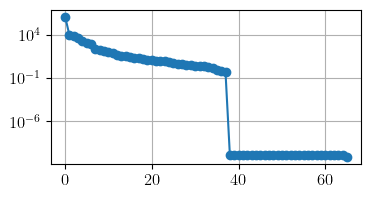

In [5]:
from lifters.plotting_tools import plot_singular_values
# compute nullspace of Y

basis, S = lifter.get_basis(Y, method="qr", eps=0.1)
print("nullspace basis:", basis.shape)

plot_singular_values(S)
plt.show()

In [6]:
A_known = lifter.get_A_known()
for Ai in A_known:
    x = lifter.get_x(lifter.get_theta())
    assert abs(x.T @ Ai @ x) <= 1e-10

In [7]:
# generate matrices from found nullspace

eps = 1
A_list = lifter.generate_matrices(basis)

max_error = -np.inf

# testing only:
# make sure all constraints hold for new setups 
for seed in range(1000):
    np.random.seed(seed)
    lifter.generate_random_unknowns()
    x = lifter.get_x()
    
    for A in A_list:
        ci = np.abs(x.T @ A @ x)
        max_error = max(max_error, ci)
        assert ci < eps, ci
print("max constraint error:", max_error)

max constraint error: 3.448743552958433e-07


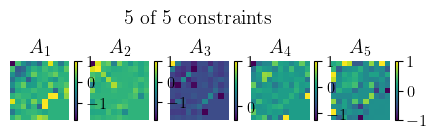

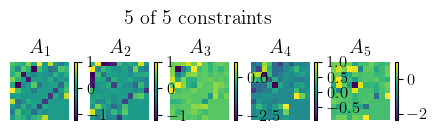

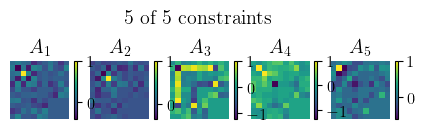

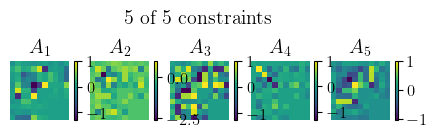

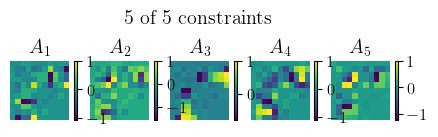

In [9]:
# plot resulting matrices
from lifters.plotting_tools import plot_matrices
chunks = len(A_list) // 5
for k in range(chunks):
    fig, ax = plot_matrices(A_list[k*5:(k+1)*5])

# 2. Solve dual problem

Using the learned matrices, we solve the dual problem

$
\begin{align} 
d_n^* = &\max_{\rho, \vc{\lambda}} -\rho \\
&\text{s.t. } \vc{Q} + \sum_{m=1}^n \lambda_m \vc{A}_m + \rho \vc{A}_0 \succeq 0
\end{align}
$

where $n \leq N_0$ denotes the number of constraints we are adding
and compare the obtained cost to the cost of the (hopefully globally optimal) solution obtain by solving the original problem with a simple local solver:

$
\begin{align}
q^* &= \min_{\vc{\theta}} f(\vc{\theta})
\end{align}
$

In [10]:
import cvxpy as cp
solver_options = {
    "CVXOPT": {
        "verbose": False,
        "refinement": 1,
        "kktsolver":"qr" # important so that we can solve with redundant constraints
    }
}
def solve_dual(Q, A_list, solver = "CVXOPT"):
    rho = cp.Variable()
    
    A_0 = np.zeros(Q.shape)
    A_0[0, 0] = 1.0
    
    H = cp.Parameter(Q.shape)
    
    H.value = Q
    H += A_0 * rho
    
    cp_variables = {}
    for i, Ai in enumerate(A_list):
        cp_variables[f"l{i}"] = cp.Variable()
        H += Ai * cp_variables[f"l{i}"]
        
    constraints = [
        H >> 0
    ]
    
    prob = cp.Problem(cp.Maximize(-rho), constraints)
    try:
        prob.solve(solver=solver, **solver_options[solver])
        return -rho.value, H.value, prob.status
    except:
        return None, None, prob.status

In [11]:
from copy import deepcopy

def find_local_minimum(a, y, verbose=False):
    local_solutions = []
    costs = []
    
    n_inits = 10
    #inits = lifter.get_inits(n_inits) # n_inits x 3
    inits = [deepcopy(lifter.unknowns)]
    
    for x_init in inits:
        x_local, msg = lifter.local_solver(a=a, y=y, x_init=x_init, verbose=verbose)
        print(msg)
        if verbose:
            print(msg)
        if x_local is not None:
            costs.append(lifter.get_cost(a=a, y=y, x=x_local))
            local_solutions.append(x_local)
    local_solutions = np.array(local_solutions)
    
    if len(costs):
        min_local_ind = np.argmin(costs)
        min_local_cost = costs[min_local_ind]
        best_local_solution = local_solutions[min_local_ind]
        return best_local_solution, min_local_cost
    return None, None

converged
converged
converged


,n,seed,local cost,dual cost,eigs,status
0,1,0,0.001173,5.809271e-09,"[-1.5149320149385639e-09, -1.2886118011915453e...",optimal
1,2,0,0.001173,6.904795e-10,"[-1.5107073019339782e-10, -2.710569476769393e-...",optimal
2,3,0,0.001173,1.533411e-08,"[-3.1315233749480797e-09, -1.5595444710439187e...",optimal
3,4,0,0.001173,1.883676e-08,"[-4.058246063446579e-09, -2.1170494354107038e-...",optimal
4,5,0,0.001173,2.856991e-09,"[-4.600286516454733e-10, -2.919093919487261e-1...",optimal
...,...,...,...,...,...,...
76,23,2,0.000215,1.915293e-07,"[-1.610839179345762e-11, 1.3168905351178204e-1...",optimal
77,24,2,0.000215,1.841174e-07,"[-8.799477024028965e-12, 6.847532230692988e-12...",optimal
78,25,2,0.000215,2.583483e-07,"[-9.796434570600325e-12, 9.288166860136007e-12...",optimal
79,26,2,0.000215,3.137937e-07,"[-1.0713634863743713e-11, 1.100462442322961e-1...",optimal


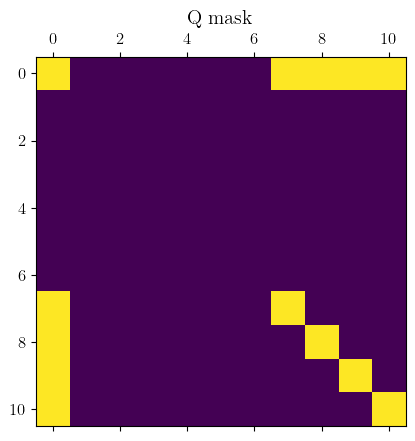

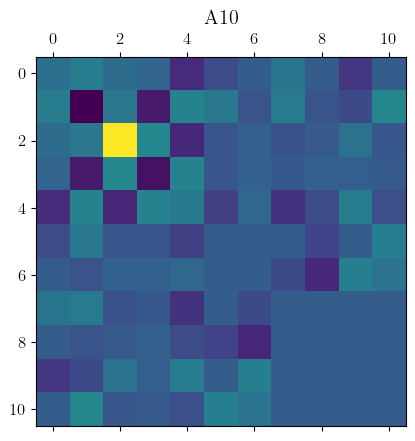

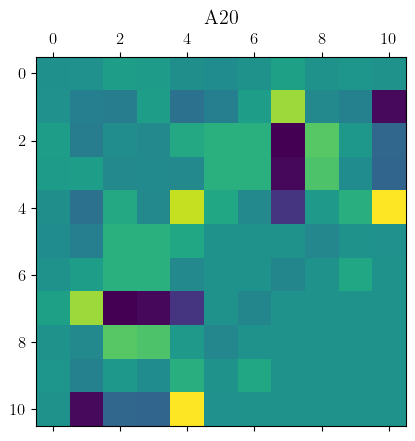

In [15]:
from copy import deepcopy
data = []
n_seeds = 3

a = lifter.landmarks
for j in range(n_seeds):
    
    # generate random measurements
    np.random.seed(j)
    Q, y = lifter.get_Q(noise=1e-1)
    
    if j == 0:
        fig, ax = plt.subplots()
        ax.matshow(Q != 0)
        ax.set_title("Q mask")
    
    # find global optimum
    xhat, local_cost = find_local_minimum(a=deepcopy(a), y=deepcopy(y), verbose=False)
    x_vec = lifter.get_x(xhat)
    local_costQ = x_vec.T @ Q @ x_vec
    assert abs(local_costQ - local_cost) < 1e-8, (local_costQ-local_cost)
    
    for i in range(1, len(A_list)):
        # solve dual
        if (j == 0) and (i % 10 == 0):
            fig, ax = plt.subplots()
            ax.matshow(A_list[i])
            ax.set_title(f"A{i}")
            
        dual_cost, H, status = solve_dual(Q, A_list[:i])
        
        eigs = np.linalg.eigvalsh(H) if H is not None else None
        data.append({
            "n": i, 
            "seed":j , 
            "dual cost":dual_cost, 
            "local cost":local_cost, 
            "eigs":eigs, 
            "status":status
        })
df = pd.DataFrame(data, columns=["n", "seed", "local cost", "dual cost", "eigs", "status"])
df

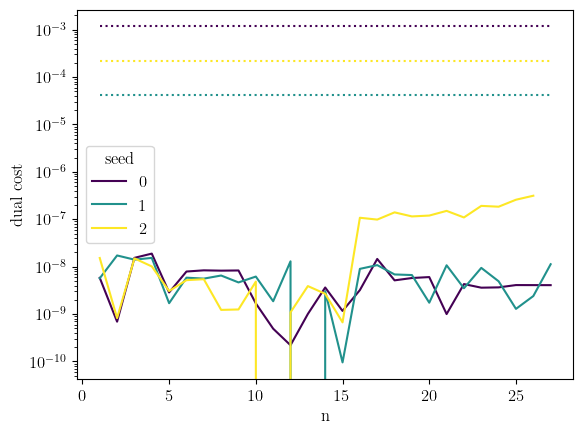

In [16]:
import seaborn as sns

palette = "viridis"

fig, ax = plt.subplots()
sns.lineplot(data=df, x="n", y="dual cost", hue="seed", ax=ax, palette=palette)
sns.lineplot(data=df, x="n", y="local cost", hue="seed", ax=ax, palette=palette, ls=":", legend=False)
ax.set_yscale("log")

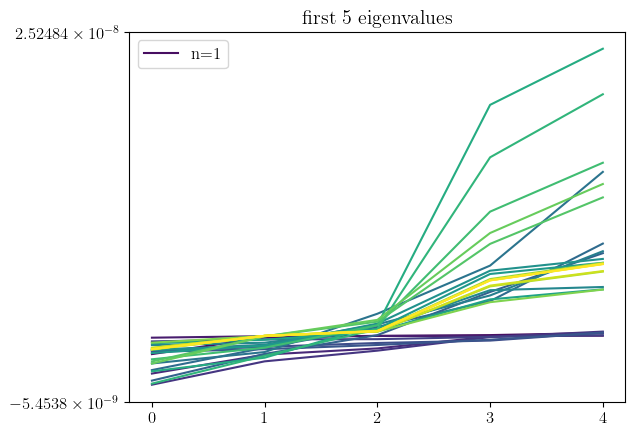

In [17]:
n_eigs = 5
for seed, df_seed in df.groupby("seed"):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap(lut=len(df_seed.n.unique()), name=palette)
    label = f"n={df_seed.iloc[0].n}"
    for n, df_n in df_seed.groupby("n"):
        assert len(df_n) == 1
        row = df_n.iloc[0]
        if row.eigs is not None:
            ax.plot(row.eigs[:n_eigs], color=cmap(n), label=label)
            label = None
    ax.set_title(f"first {n_eigs} eigenvalues")
    ax.set_xticks(range(n_eigs))
    ax.legend()
    ax.set_yscale("symlog")
    break

# 3. larger-scale study

In [19]:
#df = pd.read_pickle("_results/redundant_test_all.pkl")
df = pd.read_pickle("../_results/redundant_test.pkl") # added extra constraints
df

,d,n_poses,n_landmarks,n_known,n_missing,n_found
0,2,1,1,7,19,26
1,2,1,2,12,31,43
2,2,1,3,19,45,64
3,2,1,4,28,61,89
4,2,1,5,39,79,118
5,2,1,6,52,99,151
6,2,2,1,16,67,83
7,2,2,2,32,97,129
8,2,2,3,56,129,185
9,2,2,4,88,163,251


In [20]:
def poly_label(coeffs):
    label = ""
    for i, c in enumerate(coeffs):
        deg = len(coeffs) - i
        if deg > 1:
            if abs(c) > 1e-10:
                label += f"{c:.1f}$x^{deg}$ + "
        elif deg == 1:
            if abs(c) > 1e-10:
                label += f"{c:.1f}$x$ + "
        else:
            label += f"{c:.1f}"
    return label

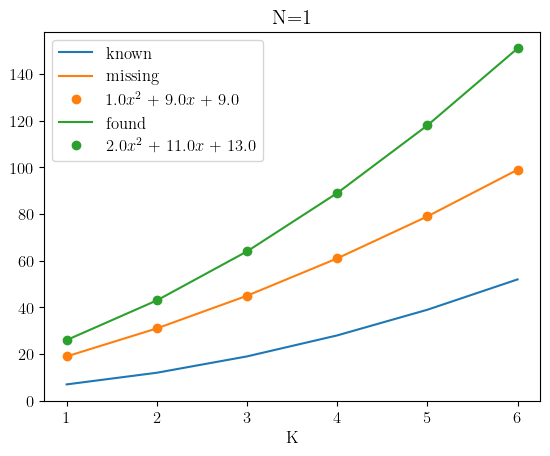

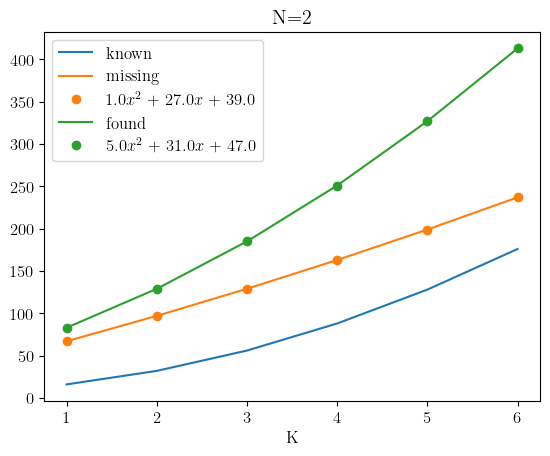

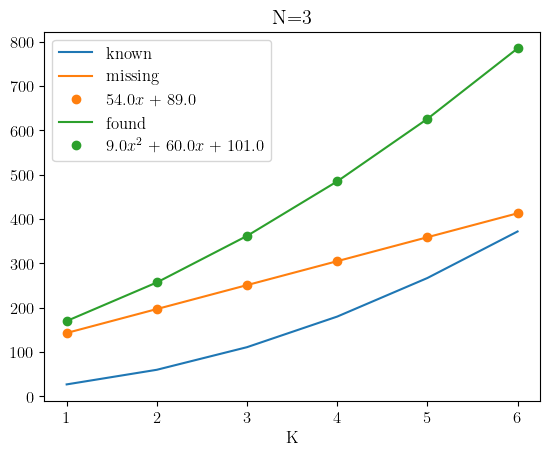

In [21]:
from scipy.optimize import curve_fit

for N, df_N in df.groupby("n_poses"):
    x = np.r_[df_N.n_landmarks]

    plt.figure()
    plt.plot(x, np.r_[df_N.n_known], label="known", color="C0")
    for i, label in enumerate(["missing", "found"]):
        y = np.r_[df_N["n_"+label]]
        plt.plot(x, y, label=label, color=f"C{i+1}")

        coeffs = np.polyfit(x, y, 2)
        
        #a2_a0, *_ = curve_fit(lambda x, a, b: a*x**2 + b, x, y)
        #a2, a0 = a2_a0
        #coeffs = [a2, 0, a0]
        #print("rounding:", coeffs)
        
        coeffs = np.round(coeffs, 1)
        poly = np.poly1d(coeffs)
        label= poly_label(poly) #f"{coeffs[0]:.1f}$x^2$ + {coeffs[1]:.1f}$x$ + {coeffs[2]:.1f}"
        plt.plot(x, poly(x), label=label, ls="", marker='o', color=f"C{i+1}")
    plt.plot()
    plt.legend()
    plt.xlabel("K")
    plt.title(f"N={N}")

# 4. Next steps

- Using the $A_m$ that we know, try to complete the basis, so that it stays sparse. 
- Finish test on landmark-based SLAM problem
- Add Lasserre hierarchy option